# Prática Guiada: Técnicas para datasets desbalanceados.

#### O problema dos datasets desbalanceados é encontrado em uma ampla variedade de problemas de aprendizado de máquina, como a detecção de comentários feitos por meio de bots, o diagnóstico de doenças ou a busca por transações fraudulentas em um sistema.

#### Existem duas abordagens principais para lidar com datasets que estão desbalanceados:

    1. Fazer um resampling da amostra para treinar o algoritmo com proporções similares.
    2. Incorporar o desbalanceamento na função de custos do algoritmo para que ele tenha incentivos para escolher os parâmetros que melhor discriminam a classe minoritária.

## Classificação de dados desbalanceados

#### A seguir, apresentamos um dataset da empresa americana Lending Club, que fornece serviços financeiros para diferentes segmentos. 

#### A seguir, vamos utilizar informação aberta do portal [lendingclub](https://www.lendingclub.com/) de empréstimos, para tentar prever quais dos créditos terminam em default. 

#### Para tanto, vamos importar as seguintes bibliotecas:

- [`pandas`](https://pandas.pydata.org/docs/), para a manipulação dos dados.
- [`seaborn`](https://seaborn.pydata.org/), para a visualização dos dados.
- [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), para dividir nossos dados em subconjuntos aleatórios de treino e teste.

- [`imblearn.over_sampling.SMOTE`](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html), uma classe de funções para realizar uma re-amostragem usando o método Synthetic Minority Over-sampling Technique ([SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/#:~:text=in%20their%202002%20paper%20named,a%20point%20along%20that%20line.)).

- [`sklearn.utils`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.utils), com uma coleção de diferentes técnicas, de checagem e validação de dados de entrada à conversões e estimações.

In [1]:
#!pip install imblearn -U
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import sklearn.utils

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


####  <span style = "color:red">Código Original.</span>
<!---
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import sklearn.utils
-->

#### Inicialmente, vamos carregar os dados contidos no arquivo `loans.csv`, 

- 'grade', 
- 'home_ownership', 
- 'emp_length_num', 
- 'sub_grade', 
- 'short_emp',
- 'dti', 
- 'term', 
- 'purpose', 
- 'int_rate', 
- 'last_delinq_none',
- 'last_major_derog_none', 
- 'revol_util', 
- 'total_rec_late_fee',
- 'payment_inc_ratio', 
- 'bad_loans'


In [2]:
loans = pd.read_csv('loans.csv',
                    low_memory = False
                   )
loans.head()

,grade,home_ownership,emp_length_num,sub_grade,short_emp,dti,term,purpose,int_rate,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,payment_inc_ratio,bad_loans
0,B,RENT,11,B2,0,27.65,36 months,credit_card,10.65,1,1,83.7,0.00,8.14350,0
1,C,RENT,1,C4,1,1.00,60 months,car,15.27,1,1,9.4,0.00,2.39320,1
2,C,RENT,11,C5,0,8.72,36 months,small_business,15.96,1,1,98.5,0.00,8.25955,0
3,C,RENT,11,C1,0,20.00,36 months,other,13.49,0,1,21.0,16.97,8.27585,0
4,A,RENT,4,A4,0,11.20,36 months,wedding,7.90,1,1,28.3,0.00,5.21533,0


####  <span style = "color:red">Código Original.</span>
<!---
loans = pd.read_csv('loans.csv',
                    low_memory = False
                   )
loans.head()
-->

## Análise exploratória

### Balanço da classe.

#### A classe que tentaremos prever é "bad loans", que indica se o empréstimo foi pago a tempo ou não. 

#### Fazendo uma contagem normalizada com o auxílio do método [`value_counts()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html), observamos que a classe está desbalanceada. Amaioria dos empréstimos são pagos a tempo.

In [3]:
loans['bad_loans'].value_counts(normalize = True)

0    0.811185
1    0.188815
Name: bad_loans, dtype: float64

####  <span style = "color:red">Código Original.</span>
<!---
loans['bad_loans'].value_counts(normalize = True)
-->

### Variáveis numéricas.

#### Podemos encontrar as variáveis numéricas relevantes observando quais são as que têm maior correlação com a classe `bad_loans`.

In [4]:
loans.corr()['bad_loans'].apply(abs).sort_values(ascending = False)

bad_loans                1.000000
int_rate                 0.227545
revol_util               0.112548
dti                      0.107652
total_rec_late_fee       0.032719
payment_inc_ratio        0.025879
short_emp                0.019498
emp_length_num           0.008342
last_delinq_none         0.003466
last_major_derog_none    0.002390
Name: bad_loans, dtype: float64

####  <span style = "color:red">Código Original.</span>
<!---
loans.corr()['bad_loans'].apply(abs).sort_values(ascending = False)
-->

In [5]:
loans.head()

,grade,home_ownership,emp_length_num,sub_grade,short_emp,dti,term,purpose,int_rate,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,payment_inc_ratio,bad_loans
0,B,RENT,11,B2,0,27.65,36 months,credit_card,10.65,1,1,83.7,0.00,8.14350,0
1,C,RENT,1,C4,1,1.00,60 months,car,15.27,1,1,9.4,0.00,2.39320,1
2,C,RENT,11,C5,0,8.72,36 months,small_business,15.96,1,1,98.5,0.00,8.25955,0
3,C,RENT,11,C1,0,20.00,36 months,other,13.49,0,1,21.0,16.97,8.27585,0
4,A,RENT,4,A4,0,11.20,36 months,wedding,7.90,1,1,28.3,0.00,5.21533,0


### Variáveis categóricas.

#### Para fazer a mesma análise em variáveis categóricas, fazemos um `groupby()` por categoria para ver diferenças relevantes no número de créditos com default.

#### Testamos inicialmente o atributo `'home_ownership'`.

In [6]:
loans.groupby('home_ownership')['bad_loans'].mean().sort_values(ascending = False)

home_ownership
OTHER       0.229050
RENT        0.209484
OWN         0.194609
MORTGAGE    0.169142
Name: bad_loans, dtype: float64

####  <span style = "color:red">Código Original.</span>
<!---
loans.groupby('home_ownership')['bad_loans'].mean().sort_values()
-->

#### Testamos também o atributo `'term'`.

In [7]:
loans.groupby('term')['bad_loans'].mean().sort_values(ascending = False)

term
 60 months    0.303757
 36 months    0.159661
Name: bad_loans, dtype: float64

####  <span style = "color:red">Código Original.</span>
<!---
loans.groupby('term')['bad_loans'].mean().sort_values()
-->

#### O atributo `'purpose'`.

In [8]:
loans.groupby('purpose')['bad_loans'].mean().sort_values(ascending = False)

purpose
small_business        0.322304
other                 0.220425
moving                0.210169
medical               0.206596
debt_consolidation    0.195932
vacation              0.187209
house                 0.180100
credit_card           0.159365
home_improvement      0.159088
wedding               0.152031
major_purchase        0.141346
car                   0.130526
Name: bad_loans, dtype: float64

####  <span style = "color:red">Código Original.</span>
<!---
loans.groupby('purpose')['bad_loans'].mean().sort_values()
-->

### Valores faltantes.

#### Podemos ainda inspecionar os valores faltantes.

In [9]:
loans.isnull().sum()

grade                    0
home_ownership           0
emp_length_num           0
sub_grade                0
short_emp                0
dti                      0
term                     0
purpose                  0
int_rate                 0
last_delinq_none         0
last_major_derog_none    0
revol_util               0
total_rec_late_fee       0
payment_inc_ratio        4
bad_loans                0
dtype: int64

####  <span style = "color:red">Código Original.</span>
<!---
loans.isnull().sum()
-->

#### Notamos que a variável `'payment_inc_ratio'` tem  $4$ valores nulos e não mostra uma [correlação](https://statisticsbyjim.com/basics/correlations/#:~:text=Direction%3A%20The%20sign%20of%20the,upward%20slope%20on%20a%20scatterplot.) muito alta com a classe `'bad_loans'`.  

#### Eliminamos, então, os valores com `'payment_inc_ratio'` desconhecido.

In [10]:
loans = loans[loans['payment_inc_ratio'].notnull()].copy()
loans.isnull().sum()

grade                    0
home_ownership           0
emp_length_num           0
sub_grade                0
short_emp                0
dti                      0
term                     0
purpose                  0
int_rate                 0
last_delinq_none         0
last_major_derog_none    0
revol_util               0
total_rec_late_fee       0
payment_inc_ratio        0
bad_loans                0
dtype: int64

####  <span style = "color:red">Código Original.</span>
<!---
loans = loans[loans['payment_inc_ratio'].notnull()].copy()
#loans.isnull().sum()
-->

#### Vamos gerar uma amostra dos dados.

In [11]:
loans.sample(10)

,grade,home_ownership,emp_length_num,sub_grade,short_emp,dti,term,purpose,int_rate,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,payment_inc_ratio,bad_loans
111237,D,RENT,9,D2,0,32.38,36 months,other,16.29,1,1,49.0,0.0,1.896060,0
85055,A,RENT,7,A1,0,11.53,36 months,debt_consolidation,6.03,1,1,21.0,0.0,4.509040,0
12050,C,RENT,11,C1,0,2.09,36 months,small_business,12.99,0,1,87.8,0.0,5.588220,0
11060,B,RENT,5,B4,0,20.12,36 months,debt_consolidation,11.49,1,1,83.8,0.0,2.094710,0
77615,B,MORTGAGE,3,B2,0,23.72,36 months,debt_consolidation,11.14,1,1,75.0,0.0,6.871200,1
39907,B,RENT,11,B2,0,7.89,36 months,credit_card,10.99,1,1,49.0,0.0,8.380000,0
100703,A,RENT,6,A2,0,20.16,36 months,other,6.62,1,1,33.6,0.0,5.308270,0
49944,D,RENT,2,D4,0,11.73,36 months,medical,19.52,0,1,86.0,0.0,0.699632,0
97097,A,MORTGAGE,11,A1,0,8.53,36 months,credit_card,6.03,1,1,25.2,0.0,9.518240,0
81378,D,MORTGAGE,4,D1,0,17.53,36 months,debt_consolidation,17.77,1,1,85.3,0.0,12.452100,0


####  <span style = "color:red">Código Original.</span>
<!---
loans.sample(10)
-->

### Modelo Preditivo: regressão logística.

#### Vamos usar Regressão Logística para prever a classe `'bad_loans'`. 


#### Mas primeiro precisamos gerar as variáveis `dummies` para os dados categóricos. Para isso vamos aplicar o método [`get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html),  que converte as variáveis categórica para indicadores numéricos.

In [12]:
loans_enconded = pd.get_dummies(loans)
loans_enconded.head()
loans_enconded.columns
#print(loans_enconded.shape)

Index(['emp_length_num', 'short_emp', 'dti', 'int_rate', 'last_delinq_none',
       'last_major_derog_none', 'revol_util', 'total_rec_late_fee',
       'payment_inc_ratio', 'bad_loans', 'grade_A', 'grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G', 'home_ownership_MORTGAGE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4',
       'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3',
       'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2',
       'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1',
       'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5',
       'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4',
       'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3',
       'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2',
       'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5', 'ter

####  <span style = "color:red">Código Original.</span>
<!---
loans_enconded = pd.get_dummies(loans)
#loans_enconded.head()
-->

#### Antes de aplicar o modelo de regressão, vamos ainda separar os dados originais em subconjuntos de treino e teste com o auxílio da função [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), eliminando aqui o atributo `'bad_loans'`.

In [13]:
training_features, test_features, \
training_target, test_target, = train_test_split(loans_enconded.drop(['bad_loans'], 
                                                                     axis = 1
                                                                    ), 
                                                 loans_enconded['bad_loans'], 
                                                 test_size = .05, 
                                                 random_state = 12
                                                ) 

####  <span style = "color:red">Código Original.</span>
<!---
training_features, test_features, \
training_target, test_target, = train_test_split(loans_enconded.drop(['bad_loans'], axis=1),
loans_enconded['bad_loans'],test_size = .1,random_state=12)
-->

#### O último passo antes de realizarmos a regressão logística de nossos dados para a classificação de nossas observações passa por importar as bibliotecas:

- [`sklearn.linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), uma classe que implementa uma regressão logística regularizada.

- [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), que computa a área sob a curva (Area under the Curve) `AUC` e Curva Característica de Operação do Receptor (Receiver Operating Characteristic Curve) `ROC`, a partir do `score` dos preditores.

- [`sklearn.metrics.classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), que constrói um relatório de texto, com as principais métricas de classificação.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

####  <span style = "color:red">Código Original.</span>
<!---
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
-->

#### Agora sim, vamos instanciar uma objeto `model` para receber o modelo de regressão logística e o ajustamos aos dados de treinamento com o método [`.fit()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.fit). 

#### Repare que a regressão leva o parâmetro `C` que opera como o inverso da força de regularização; devendo ser uma flutuação positiva, em que valores menores especificam uma regularização mais forte.

In [15]:
#{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}
model = LogisticRegression(C = 1e10, 
                           max_iter = 2000,
                           solver = 'lbfgs'                           
                          )

model.fit(training_features, 
          training_target
         )

LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

####  <span style = "color:red">Código Original.</span>
<!---
model = LogisticRegression(C = 1e10)
model.fit(training_features, 
          training_target
         )
-->

#### Geramos nossas previsões dos rótulos para o subconjunto de teste com o método [`.predict()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict).

In [16]:
y_pred = model.predict(test_features)

####  <span style = "color:red">Código Original.</span>
<!---
y_pred = model.predict(test_features)
-->

#### Vamos agora aplicar a função [`roc_auc_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) aos subconjuntos de teste e de previsão, para entendermos o desempenho de nossa classificação binária.

In [17]:
roc_auc_score(test_target, 
              y_pred
             )

0.5090886206281099

####  <span style = "color:red">Código Original.</span>
<!---
roc_auc_score(test_target,y_pred)
-->

#### Podemos ainda plotar a representação gráfica da curva ROC, comparando a sensitividade (TPR) e a especificidade do mesmo (1 – FPR), como fazemos a seguir.

In [18]:
from sklearn.metrics import roc_curve
fpr_log,tpr_log,thr_log = roc_curve(test_target, 
                                    y_pred
                                   )

In [19]:
df = pd.DataFrame(dict(fpr = fpr_log, 
                       tpr = tpr_log, 
                       thr = thr_log
                      )
                 )

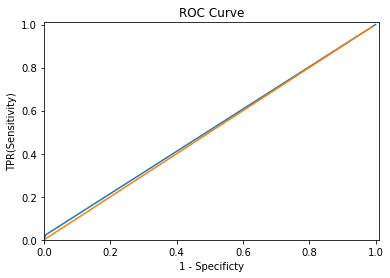

In [20]:
import matplotlib.pyplot as plt
plt.axis([0, 1.01, 0, 1.01])

plt.xlabel('1 - Specificty')

plt.ylabel('TPR(Sensitivity)')

plt.title('ROC Curve')

plt.plot(df['fpr'],
         df['tpr']
        )

plt.plot(np.arange(0,1, 
                   step = 0.01
                  ), 
         np.arange(0,1, 
                   step = 0.01
                  )
        )

plt.show() 

#### Quando avaliamos o modelo sobre dados não observados, a área sob a curva é muito próxima de 0.5. Especificamente, o recall na hora de encontrar "maus créditos" é muito ruim. Um dos problemas que temos para fazer um bom modelo é o desbalanceamento de dados. 

#### Vejamos a seguir o reporte da classificação [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), mostrando as métricas da mesma.

In [21]:
print(classification_report(test_target,
                            y_pred
                           )
     )

              precision    recall  f1-score   support

           0       0.81      1.00      0.89      4958
           1       0.53      0.02      0.04      1173

    accuracy                           0.81      6131
   macro avg       0.67      0.51      0.47      6131
weighted avg       0.76      0.81      0.73      6131



####  <span style = "color:red">Código Original.</span>
<!---
print(classification_report(test_target,
                            y_pred
                           )
     )
-->

#### Vamos tentar duas soluções possíveis.

## Oversampling

#### Para aumentar a representação da classe minoritária vamos fazer um oversampling usando o algoritmo [SMOTE](https://www.kite.com/blog/python/smote-python-imbalanced-learn-for-oversampling/) (Synthetic Minority Oversample) do pacote imblearn.

#### Este algoritmo gera novos dados usando a técnica dos `k` vizinhos mais próximos. Para gerar um ponto novo:

- É escolhido um ponto da classe minoritária ao acaso e seus `k` vizinhos mais próximos.
- Um desses vizinhos é escolhido ao acaso.
- O vetor é calculado entre o ponto e o vizinho selecionados ao acaso e multiplicado por um número aleatório entre $0$ e $1$.
- O ponto aleatório dentro do vetor é o novo dado para o oversampling.

####  Para cada observação que pertence à classe sub-representada, o algoritmo [`SMOTE()`](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html#imblearn-over-sampling-smote) obtém seus `k` vizinhos mais próximos e sintetiza uma nova instância do rótulo minoritário em um local aleatório na linha entre a observação atual e o vizinho mais próximo. 

In [22]:
sm = SMOTE(random_state = 12
          )
x_train_res, y_train_res = sm.fit_resample(training_features, 
                                         training_target
                                        )

print(training_features.shape)
print(training_target.shape)
print(x_train_res.shape)
print(y_train_res.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(116472, 69)
(116472,)
(188990, 69)
(188990,)


####  <span style = "color:red">Código Original.</span>
<!---
sm = SMOTE(random_state = 12
          )
x_train_res, y_train_res = sm.fit_sample(training_features, 
                                         training_target
                                        )

print(training_features.shape)
print(training_target.shape)
print(x_train_res.shape)
print(y_train_res.shape)
-->

#### Após repetirmos o processo de separação da reamostragem dos dados entre subconjuntos de treino e teste, fazemos um novo ajuste dos pontos com o método [`.fit()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.fit). 

In [23]:
model = LogisticRegression(C = 1e10, 
                           max_iter = 2000,
                           solver = 'liblinear'                           
                          )

model.fit(x_train_res,
          y_train_res
         )

LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

####  <span style = "color:red">Código Original.</span>
<!---
model = LogisticRegression(C = 1e10, 
                           max_iter = 2000,
                           solver = 'liblinear'                           
                          )

model.fit(x_train_res,
          y_train_res
         )
-->

#### E realizamos novas previsões com o método [`.predict()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict).

In [24]:
y_pred = model.predict(test_features)

####  <span style = "color:red">Código Original.</span>
<!---
y_pred = model.predict(test_features)
-->

#### Aplicamos novamente a função [`roc_auc_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) aos subconjuntos de teste e de previsão que incorreram em reamostragem e observamos novamente o desempenho de nossa classificação binária.

In [25]:
roc_auc_score(test_target, 
              y_pred
             )

0.6300682768503512

####  <span style = "color:red">Código Original.</span>
<!---
roc_auc_score(test_target, 
              y_pred
             )
-->

#### Podemos novamente plotar a representação gráfica da curva ROC, comparando a sensitividade (TPR) e a especificidade do mesmo (1 – FPR), fazendo:

In [26]:
fpr_log,tpr_log,thr_log = roc_curve(test_target, 
                                    y_pred
                                   )

In [27]:
df_res = pd.DataFrame(dict(fpr = fpr_log, 
                       tpr = tpr_log, 
                       thr = thr_log
                      )
                 )

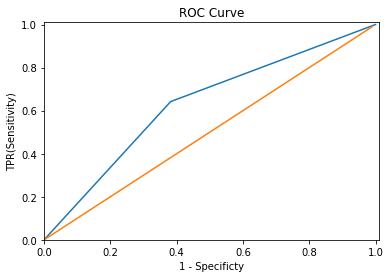

In [28]:
plt.axis([0, 1.01, 0, 1.01])

plt.xlabel('1 - Specificty')

plt.ylabel('TPR(Sensitivity)')

plt.title('ROC Curve')

plt.plot(df_res['fpr'],
         df_res['tpr']
        )

plt.plot(np.arange(0,1, 
                   step = 0.01
                  ), 
         np.arange(0,1, 
                   step = 0.01
                  )
        )

plt.show()

#### Reavaliando o modelo sobre dados não observados, a área sob a curva tem um melhora para 56% do total. Especificamente, o recall na hora de encontrar "maus créditos" sobe. 

#### Vejamos a seguir o reporte da classificação [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), mostrando as métricas da mesma.

In [29]:
print(classification_report(test_target, 
                            y_pred
                           )
     )

              precision    recall  f1-score   support

           0       0.88      0.62      0.73      4958
           1       0.28      0.64      0.39      1173

    accuracy                           0.62      6131
   macro avg       0.58      0.63      0.56      6131
weighted avg       0.77      0.62      0.66      6131



####  <span style = "color:red">Código Original.</span>
<!---
print(classification_report(test_target, 
                            y_pred
                           )
     )
-->

##  <span style = "color:blue">Prática Independente.</span>

# Class Weights

#### A outra técnica que podemos usar para corrigir o desbalanceamento dos dados é incorporar na função de custos do algoritmo um peso maior para os erros de treinamento cometidos nos pontos da classe minoritária.

#### Implemente a Regressão Logística com o parâmetro `class_weight`, que mude a ponderação das classes. Ajuste novamente o modelo, faça novas previsões e aplice o conceito de curva `ROC` aos seus resultados. Plote também o gráfico da curva `ROC` e estude o relatório da classificação.

#### Discuta como é o desempenho do novo modelo em relação à regressão logística original.  Faz sentido aplicar esta correção junto com o algoritmo `SMOTE`?

In [30]:
#Instanciando o modelo indicando o parâmetro class weight
model = LogisticRegression(C = 1e10, 
                           max_iter = 2000,
                           solver = 'liblinear',
                           class_weight='balanced'
                          )

####  <span style = "color:red">Código Original.</span>
<!---
model = LogisticRegression(C = 1e10, 
                           class_weight = 'balanced'
                          )
-->

In [31]:
#Ajustando modelo no dataset desbalanceado
model.fit(training_features, 
         training_target)

LogisticRegression(C=10000000000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

####  <span style = "color:red">Código Original.</span>
<!---
model.fit(training_features, 
          training_target
         )
-->

In [32]:
#Predições
y_pred = model.predict(test_features)

In [33]:
#Score
roc_auc_score(test_target, 
              y_pred
             )

0.6313106823661467

####  <span style = "color:red">Código Original.</span>
<!---
y_pred = model.predict(test_features)
-->

In [34]:
#Proporção de acerto e erro de cada combinação predito/verdadeiro possível
fpr_log,tpr_log,thr_log = roc_curve(test_target, 
                                    y_pred
                                   )

####  <span style = "color:red">Código Original.</span>
<!---
roc_auc_score(test_target, 
              y_pred
             )
-->

In [35]:
#Dataframe com as combinações acima
df = pd.DataFrame(dict(fpr = fpr_log, 
                       tpr = tpr_log, 
                       thr = thr_log
                      )
                 )

####  <span style = "color:red">Código Original.</span>
<!---
fpr_log,tpr_log,thr_log = roc_curve(test_target, 
                                    y_pred
                                   )
-->

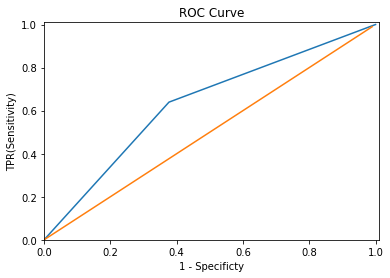

In [36]:
#Curva ROC
plt.axis([0, 1.01, 0, 1.01])

plt.xlabel('1 - Specificty')

plt.ylabel('TPR(Sensitivity)')

plt.title('ROC Curve')

plt.plot(df['fpr'],
         df['tpr']
        )

plt.plot(np.arange(0,1, 
                   step = 0.01
                  ), 
         np.arange(0,1, 
                   step = 0.01
                  )
        )

plt.show() 

Vemos que temos de fato uma melhora considerável na assertividade modelo ao utilizar o parâmetro class weight pra levar em conta o desbalanceamento das classes. 

Se faz sentido utilizá-lo com o SMOTE, ao meu ver não: já que o parâmetro está levando em conta justamente em consideração que há uma diferença grande de quantidade entre as duas classes. O SMOTE faz justamente o contrário, isto é, cria dados sintéticos como resolução deste problema.

Porém, vamos aplicar o mesmo processo do class weight com o SMOTE e empiricamente entendermos como o modelo se comporta em suas previsões e performance.

####  <span style = "color:red">Código Original.</span>
<!---
df_bal = pd.DataFrame(dict(fpr = fpr_log, 
                       tpr = tpr_log, 
                       thr = thr_log
                      )
                 )
-->

####  <span style = "color:red">Código Original.</span>
<!---
plt.axis([0, 1.01, 0, 1.01])

plt.xlabel('1 - Specificty')

plt.ylabel('TPR(Sensitivity)')

plt.title('ROC Curve')

plt.plot(df_bal['fpr'],
         df_bal['tpr']
        )

plt.plot(np.arange(0,1, 
                   step = 0.01
                  ), 
         np.arange(0,1, 
                   step = 0.01
                  )
        )

plt.show()
-->

####  <span style = "color:red">Código Original.</span>
<!---
print(classification_report(test_target, 
                            y_pred
                           )
     )
-->

#### SMOTE + Class Weight

In [51]:
#Instanciado modelo com parâmetro peso das classes
model = LogisticRegression(C = 1e10, 
                           max_iter = 2000,
                           solver = 'liblinear', 
                           class_weight='balanced')

####  <span style = "color:red">Código Original.</span>
<!---
print(x_train_res.shape)
print(y_train_res.shape)
-->

In [52]:
#Ajustando novo modelo com os dados balanceados
model.fit(x_train_res,
          y_train_res
         )

LogisticRegression(C=10000000000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

####  <span style = "color:red">Código Original.</span>
<!---
model = LogisticRegression(C = 1e10, 
                           max_iter = 2000,
                           class_weight = 'balanced',
                           solver = 'liblinear'                           
                          )

model.fit(x_train_res,
          y_train_res
         )
-->

In [53]:
#Predições
y_pred = model.predict(test_features)

####  <span style = "color:red">Código Original.</span>
<!---
y_pred = model.predict(test_features)
-->

In [54]:
#Score
roc_auc_score(test_target, 
              y_pred
             )

0.6300682768503512

####  <span style = "color:red">Código Original.</span>
<!---
roc_auc_score(test_target, 
              y_pred
             )
-->

In [55]:
#Proporção de acerto e erro de combinações predito/verdadeiro possíveis
fpr_log,tpr_log,thr_log = roc_curve(test_target, 
                                    y_pred
                                   )

####  <span style = "color:red">Código Original.</span>
<!---
fpr_log,tpr_log,thr_log = roc_curve(test_target, 
                                    y_pred
                                   )
-->

In [56]:
#Dataframe com as combinações acima
df = pd.DataFrame(dict(fpr = fpr_log, 
                       tpr = tpr_log, 
                       thr = thr_log
                      )
                 )

####  <span style = "color:red">Código Original.</span>
<!---
df_res = pd.DataFrame(dict(fpr = fpr_log, 
                       tpr = tpr_log, 
                       thr = thr_log
                      )
                 )
-->

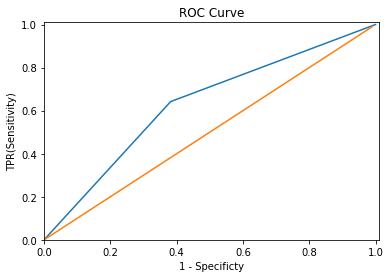

In [57]:
#Curva ROC
plt.axis([0, 1.01, 0, 1.01])

plt.xlabel('1 - Specificty')

plt.ylabel('TPR(Sensitivity)')

plt.title('ROC Curve')

plt.plot(df['fpr'],
         df['tpr']
        )

plt.plot(np.arange(0,1, 
                   step = 0.01
                  ), 
         np.arange(0,1, 
                   step = 0.01
                  )
        )

plt.show() 

O nosso score e a nossa curva roc são bem próximas: não houveram melhoras significativas. O que nos leva a compreender que a nossa hipótese inicial faz sentido: não há necessidade de aplicar o parâmetro que leva em conta o desbalanceamento das classes se houve a criação de dados a partir da técnica SMOTE de criação de mais dados da classe minoritária. Neste caso, os dois são técnicas diferentes e devem ser escolhidos e pensados de acordo com os dados que se tem em mãos. 

####  <span style = "color:red">Código Original.</span>
<!---
plt.axis([0, 1.01, 0, 1.01])

plt.xlabel('1 - Specificty')

plt.ylabel('TPR(Sensitivity)')

plt.title('ROC Curve')

plt.plot(df_res['fpr'],
         df_res['tpr']
        )

plt.plot(np.arange(0,1, 
                   step = 0.01
                  ), 
         np.arange(0,1, 
                   step = 0.01
                  )
        )

plt.show()

-->

####  <span style = "color:red">Código Original.</span>
<!---
print(classification_report(test_target, 
                            y_pred
                           )
     )
-->